In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import joblib
import math
import ast
import logging
from pathlib import Path
from msig import Motif, NullModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load YAML configuration
config_path = "config.yaml"  # Ensure this path is correct
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Convert base_dir to absolute
BASE_DIR = Path(config["base_dir"]).resolve()

# Convert other paths to absolute using BASE_DIR
RESULTS_DIR = BASE_DIR / config["results_dir"]
RESULTS_MOTIF_DIR = BASE_DIR / config["results_motif_dir"]
IMAGES_DIR = BASE_DIR / config["images_dir"]
DATA_DIR = BASE_DIR / config["data_dir"]
DATASET_PATH = BASE_DIR / config["dataset_path"]

# Extract remaining parameters from YAML
TOWNSHIP_NAME = config["township_name"]
VARIABLES = config["variables"]
NORMALIZE_FLAGS = config["normalize_flags"]
STUMPY_EXCL_ZONE_DENOM = config["stumpy_excl_zone_denom"]
TOP_K_MP = config["top_k_mp"]
INCLUDE = config["include"]
NORMALIZE = config["normalize"]
SUBSEQUENCES_LENGTHS = config["subsequences_lengths"]
NTOP_MOTIFS = config["ntop_motifs"]
MOTIF_SIZE = config["motif_size"]
LOOKBACK_PERIOD = config["lookback_period"]
STEP = config["step"]
FORECAST_PERIOD = config["forecast_period"]

# Print resolved paths for debugging
print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")
print(f"Dataset path: {DATASET_PATH}")

# Handling different environments
if '__file__' in globals():
    # For standalone scripts
    base_dir = Path(__file__).parent.resolve()
else:
    # For Jupyter or interactive environments
    base_dir = Path(os.getcwd()).resolve()

# Add the parent directory of `utils` to the Python path
sys.path.append(str(base_dir / "../"))

Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity
Dataset path: /home/mgsilva/motifpred/data/populationdensity/hourly_township.csv


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices"]]

In [3]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_univar = data[0]
data_df

,,sum_terminals
one_time,township_name,
2021-09-15 00:00:00,Avenidas Novas,260700.0
2021-09-15 01:00:00,Avenidas Novas,276675.0
2021-09-15 02:00:00,Avenidas Novas,284563.0
2021-09-15 03:00:00,Avenidas Novas,279563.0
2021-09-15 04:00:00,Avenidas Novas,281460.0
...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0
2021-11-30 20:00:00,Avenidas Novas,352361.0
2021-11-30 21:00:00,Avenidas Novas,388246.0


In [4]:
# Set global style for scientific plots
plt.rcParams.update({
    "font.family": "serif",  # Use a serif font for better readability in papers
    "font.size": 14,         # Increase font size for clarity
    "axes.titlesize": 16,    # Larger title font size
    "axes.labelsize": 14,    # Axis label size
    "xtick.labelsize": 12,   # Tick size for x-axis
    "ytick.labelsize": 12,   # Tick size for y-axis
    "legend.fontsize": 12,   # Legend font size
    "figure.figsize": (6, 4) # Standard paper figure size
})

for i, row in top_motifs.iterrows():
    motif_indices = sorted(ast.literal_eval(row["Indices"]))

    # Get the motif subsequences and Z-normalize them
    motif_subsequences = []
    for indice in motif_indices:
        seq = data_univar[indice:indice + MOTIF_SIZE]
        if len(seq) == MOTIF_SIZE:  # Ensure valid motif length
            norm_seq = (seq - np.mean(seq)) / np.std(seq)
            motif_subsequences.append(norm_seq)

    if not motif_subsequences:
        print(f"Skipping motif {i} due to empty subsequences.")
        continue

    motif_subsequences = np.array(motif_subsequences)

    # Create subplots with better spacing
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

    # Plot normalized motif subsequences
    axs[0].plot(motif_subsequences.T, color="black", alpha=0.5, linewidth=1)
    axs[0].set_title("Normalized Subsequences", fontsize=16)
    axs[0].set_xlabel("Time", fontsize=14)
    axs[0].grid(True, linestyle="--", alpha=0.5)

    # Plot original time series with motif locations
    axs[1].plot(data_univar, color="black", alpha=0.7, linewidth=1.5)
    for indice in motif_indices:
        axs[1].axvline(x=indice, color="red", linestyle="--", linewidth=1.2, alpha=0.5, label="Motif Occurrence" if indice == motif_indices[0] else "")
    axs[1].set_title("Time Series", fontsize=16)
    axs[1].set_xlabel("Time", fontsize=14)
    axs[1].set_ylabel("Terminals", fontsize=14)
    axs[1].grid(True, linestyle="--", alpha=0.5)

    # Add legend for clarity
    axs[1].legend(loc="upper right", frameon=True)

    # Save as high-quality PNG or PDF for publication
    plt.savefig(IMAGES_DIR / f"top_motif_{i+1}.png", dpi=300, bbox_inches="tight")
    plt.savefig(IMAGES_DIR / f"top_motif_{i+1}.pdf", bbox_inches="tight")  # Optional PDF for papers
    plt.close()


In [5]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [6]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNSeries"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 22
Test Loss: 91.41920471191406, Test MAE: 6.988628387451172, Test RMSE: 9.561339378356934
Evaluating motif 5 with size 12 and 47 indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 0
Test Loss: 105.46272277832031, Test MAE: 8.154031753540039, Test RMSE: 10.26950454711914
Evaluating motif 23 with size 12 and 46 indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 8
Test Loss: 154.01226806640625, Test MAE: 10.450756072998047, Test RMSE: 12.410167694091797
Evaluating motif 11 with size 12 and 44 indexes
X_series shape: torch.Size([1050,

Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 36
Test Loss: 106.8893814086914, Test MAE: 8.065460205078125, Test RMSE: 10.33873176574707
Best hyperparameters: {'learning_rate': 4.457545228567014e-05, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 32}
Early stopping at epoch 47, with best epoch being 36


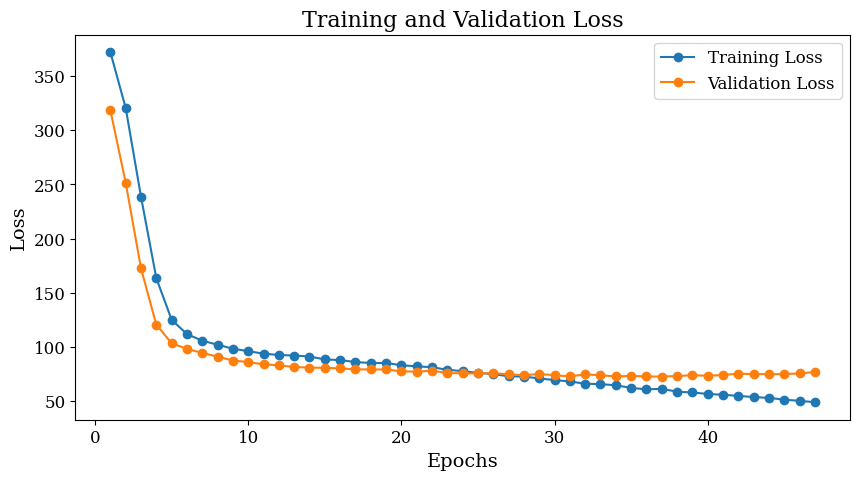

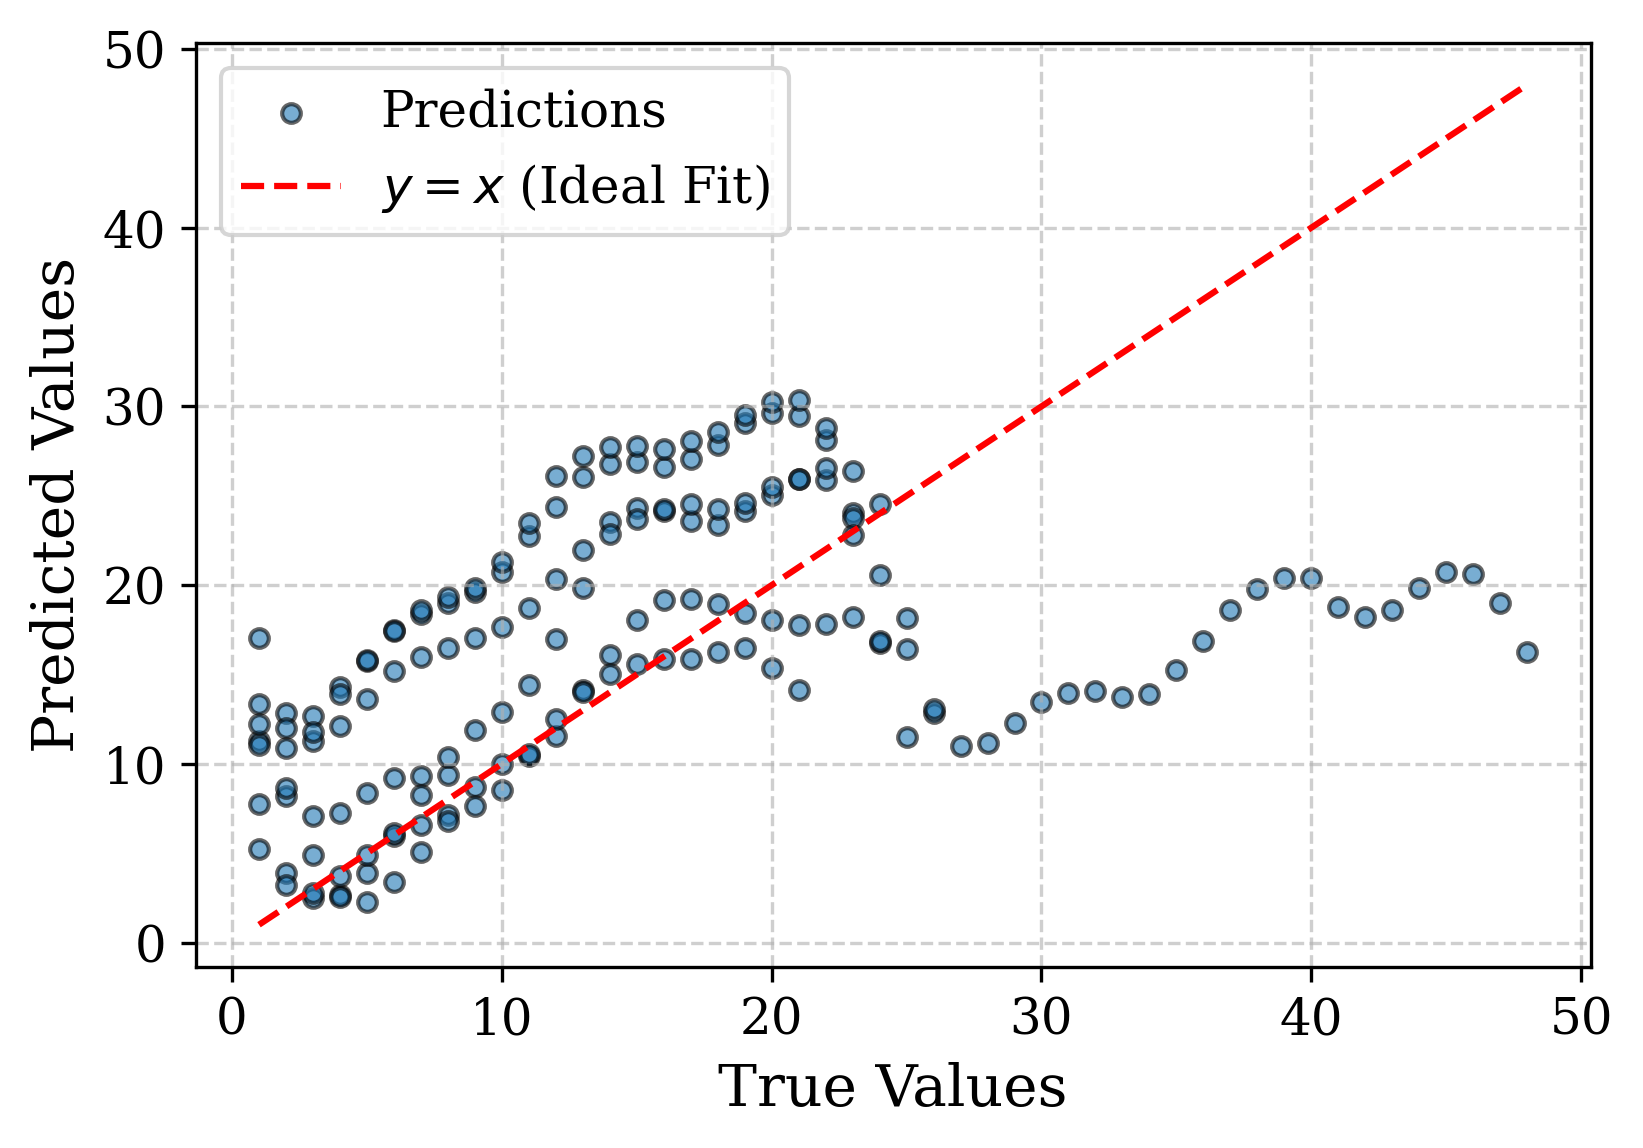

Evaluating motif 5 with size 12 and 47 indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 14
Test Loss: 127.44107818603516, Test MAE: 9.772623062133789, Test RMSE: 11.288980484008789
Best hyperparameters: {'learning_rate': 1.5104703268959782e-05, 'num_layers': 1, 'batch_size': 4, 'hidden_size_layer_0': 16}
Early stopping at epoch 25, with best epoch being 14


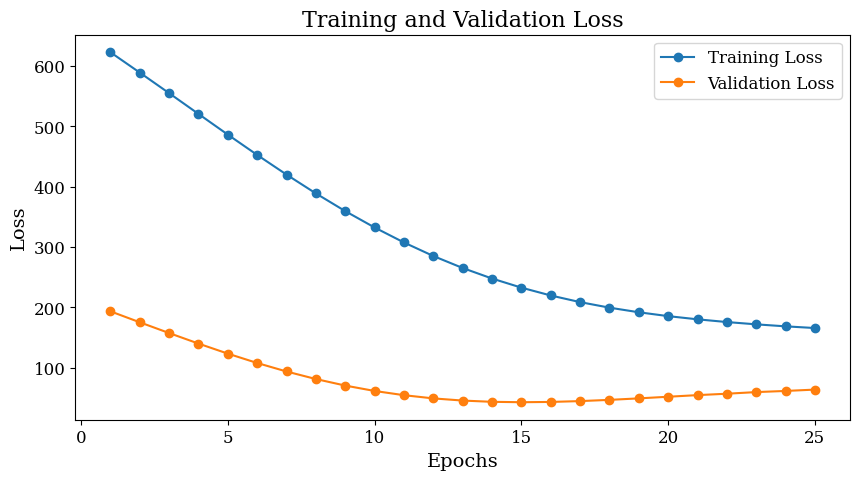

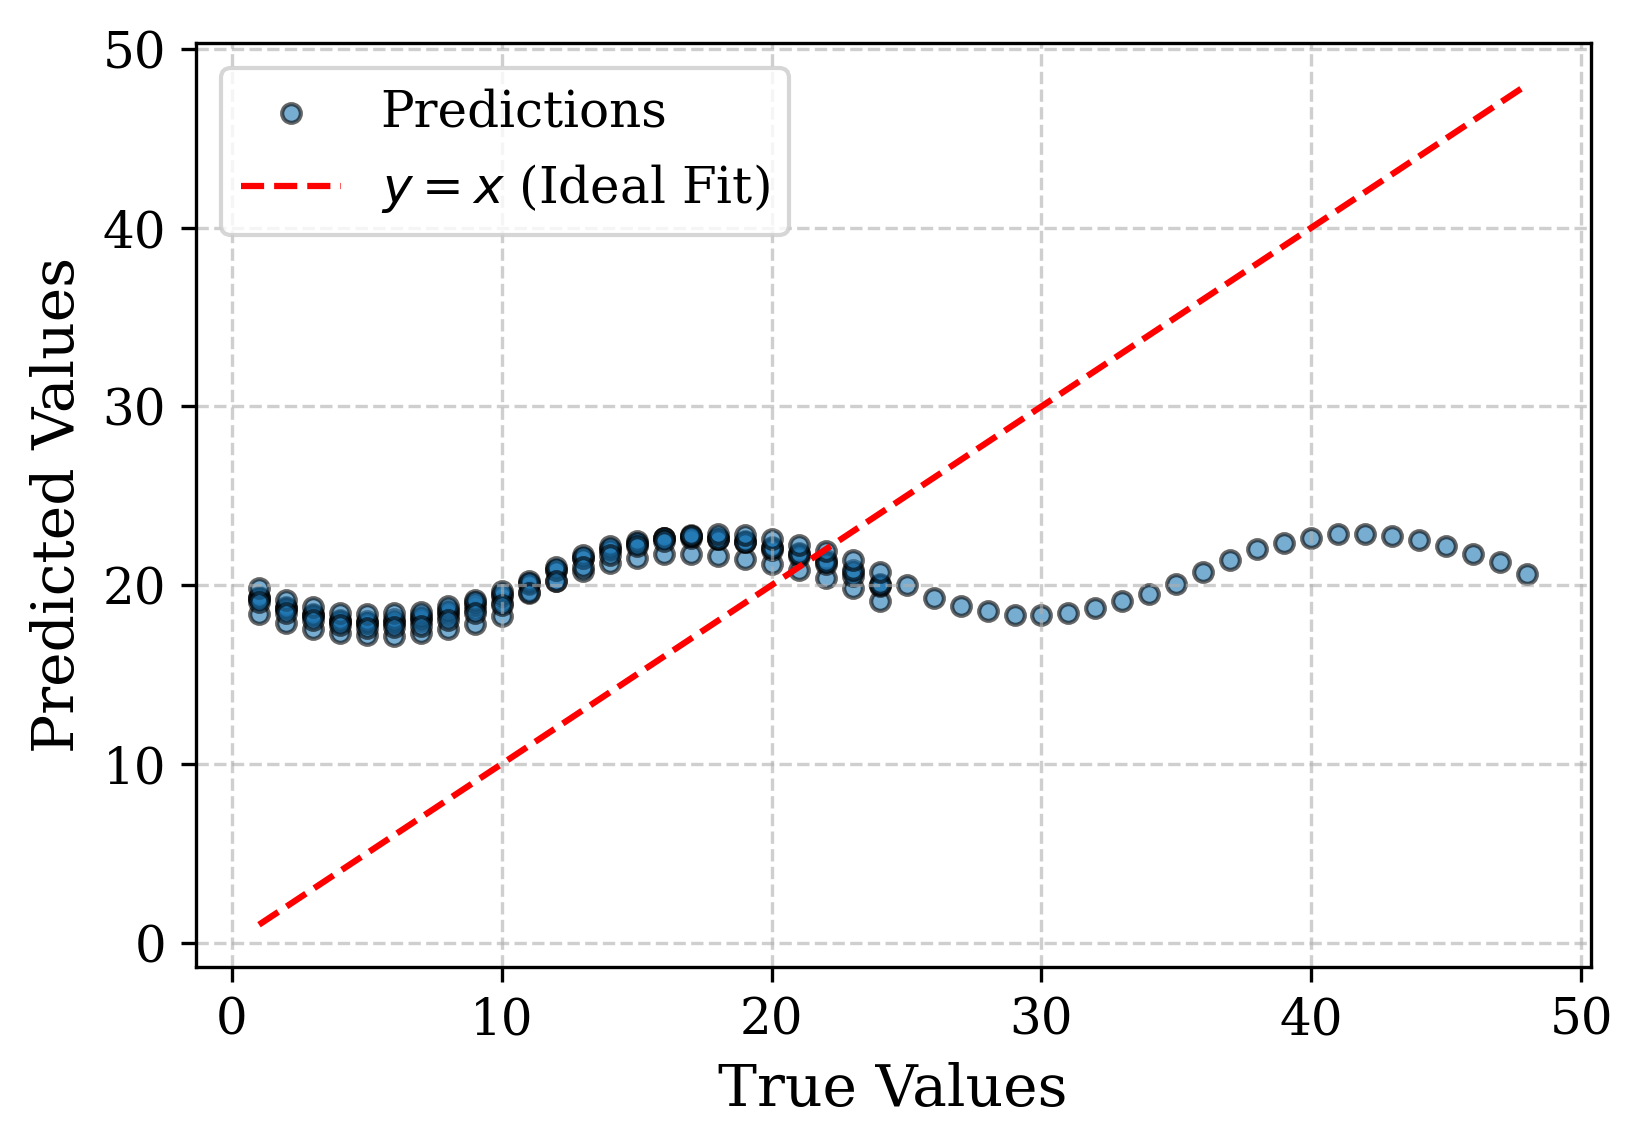

Evaluating motif 23 with size 12 and 46 indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 1
Test Loss: 146.1736297607422, Test MAE: 9.245593070983887, Test RMSE: 12.090229034423828
Best hyperparameters: {'learning_rate': 0.0006869640877901509, 'num_layers': 4, 'batch_size': 4, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 16, 'hidden_size_layer_2': 128, 'hidden_size_layer_3': 64}
Early stopping at epoch 12, with best epoch being 1


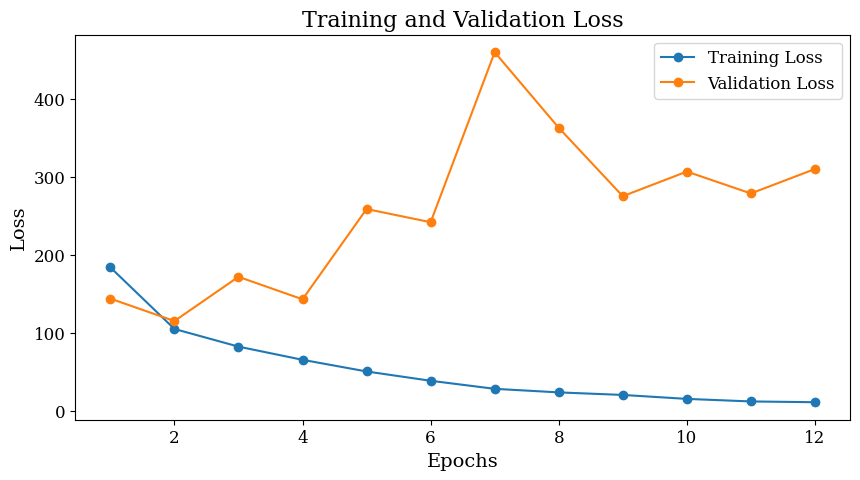

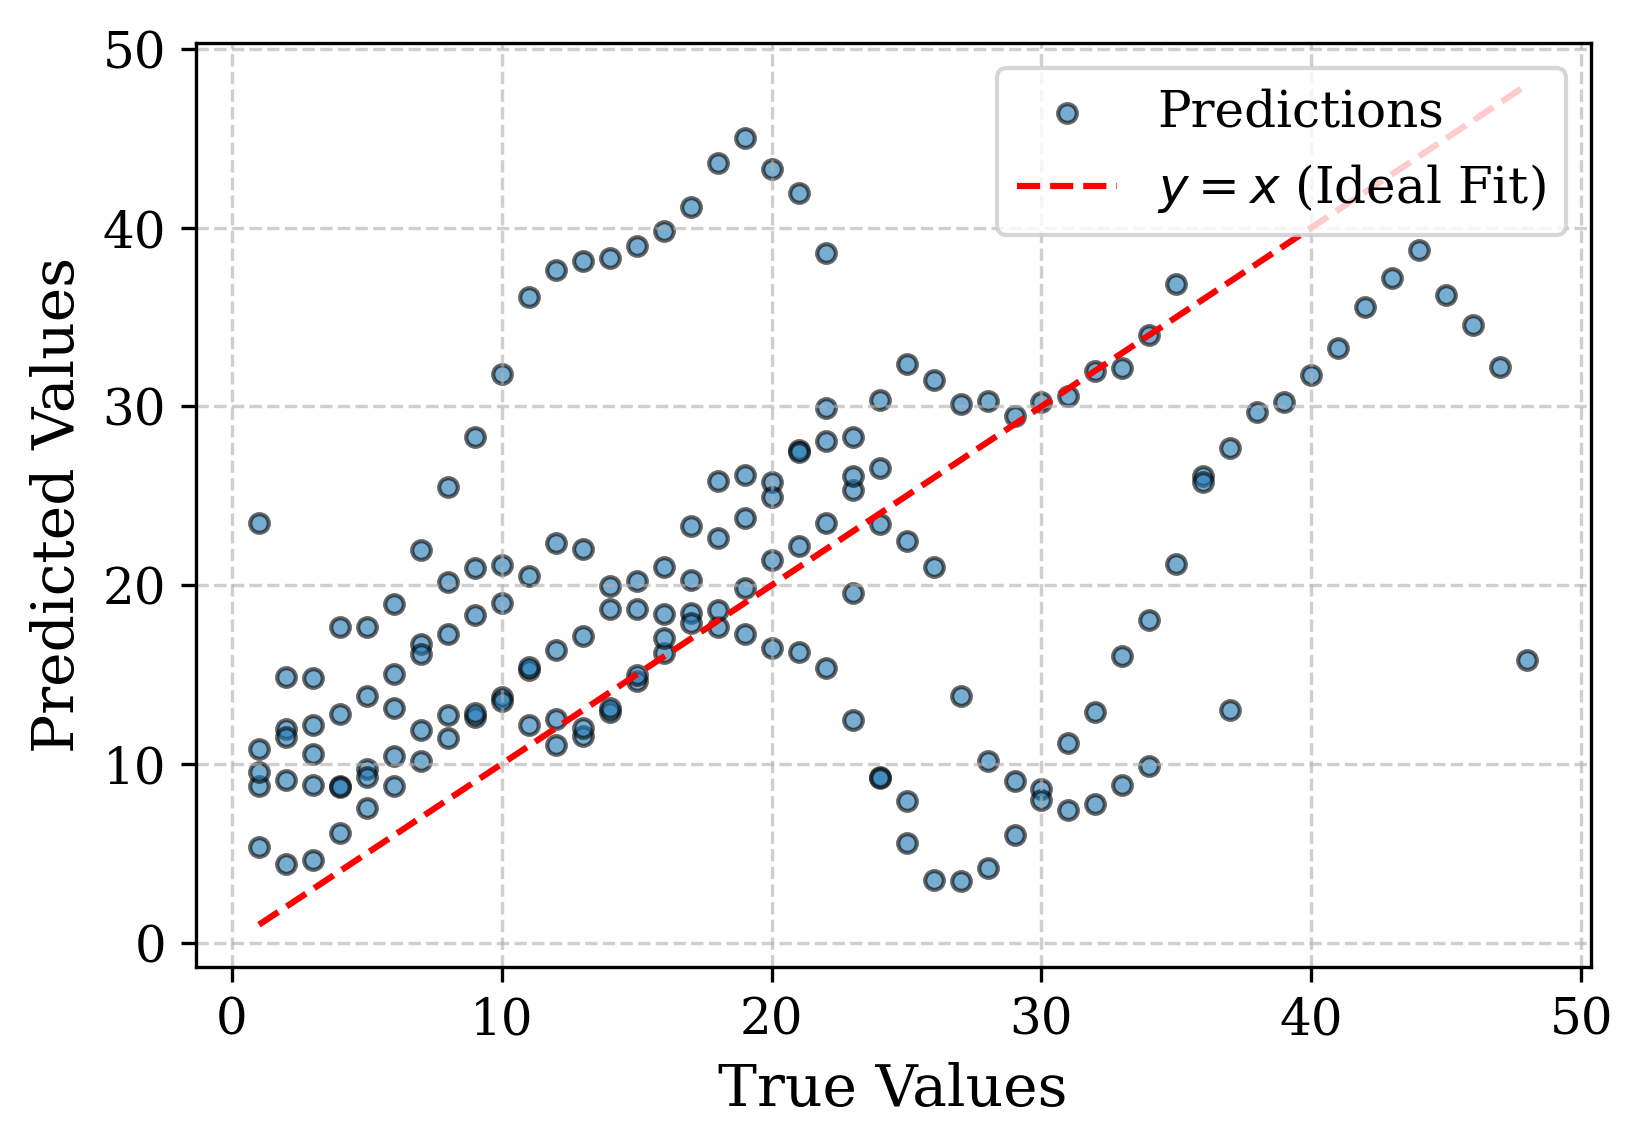

Evaluating motif 11 with size 12 and 44 indexes
X_series shape: torch.Size([1050, 504, 1])
X_indices shape: torch.Size([1050, 15, 1])
X_mask shape: torch.Size([1050, 504])
y shape: torch.Size([1050, 1])
Best epoch: 0
Test Loss: 212.32359313964844, Test MAE: 10.650553703308105, Test RMSE: 14.571328163146973
Best hyperparameters: {'learning_rate': 0.0008109974293376018, 'num_layers': 3, 'batch_size': 4, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 256}
Early stopping at epoch 12, with best epoch being 0


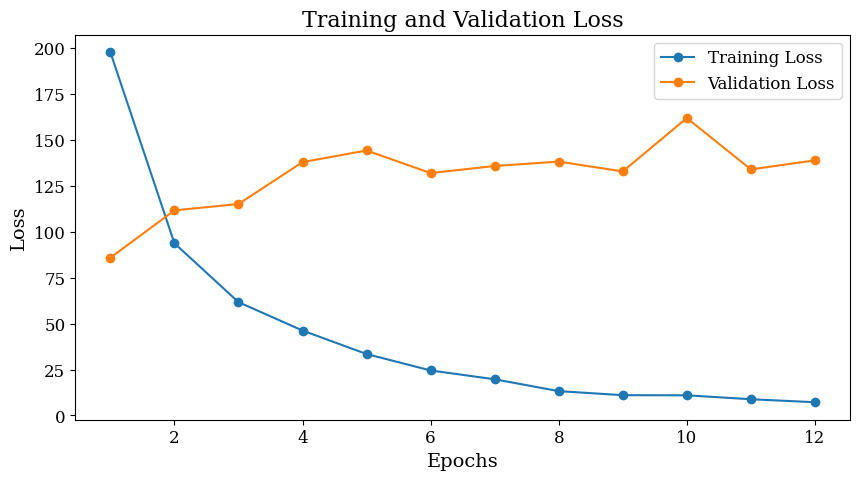

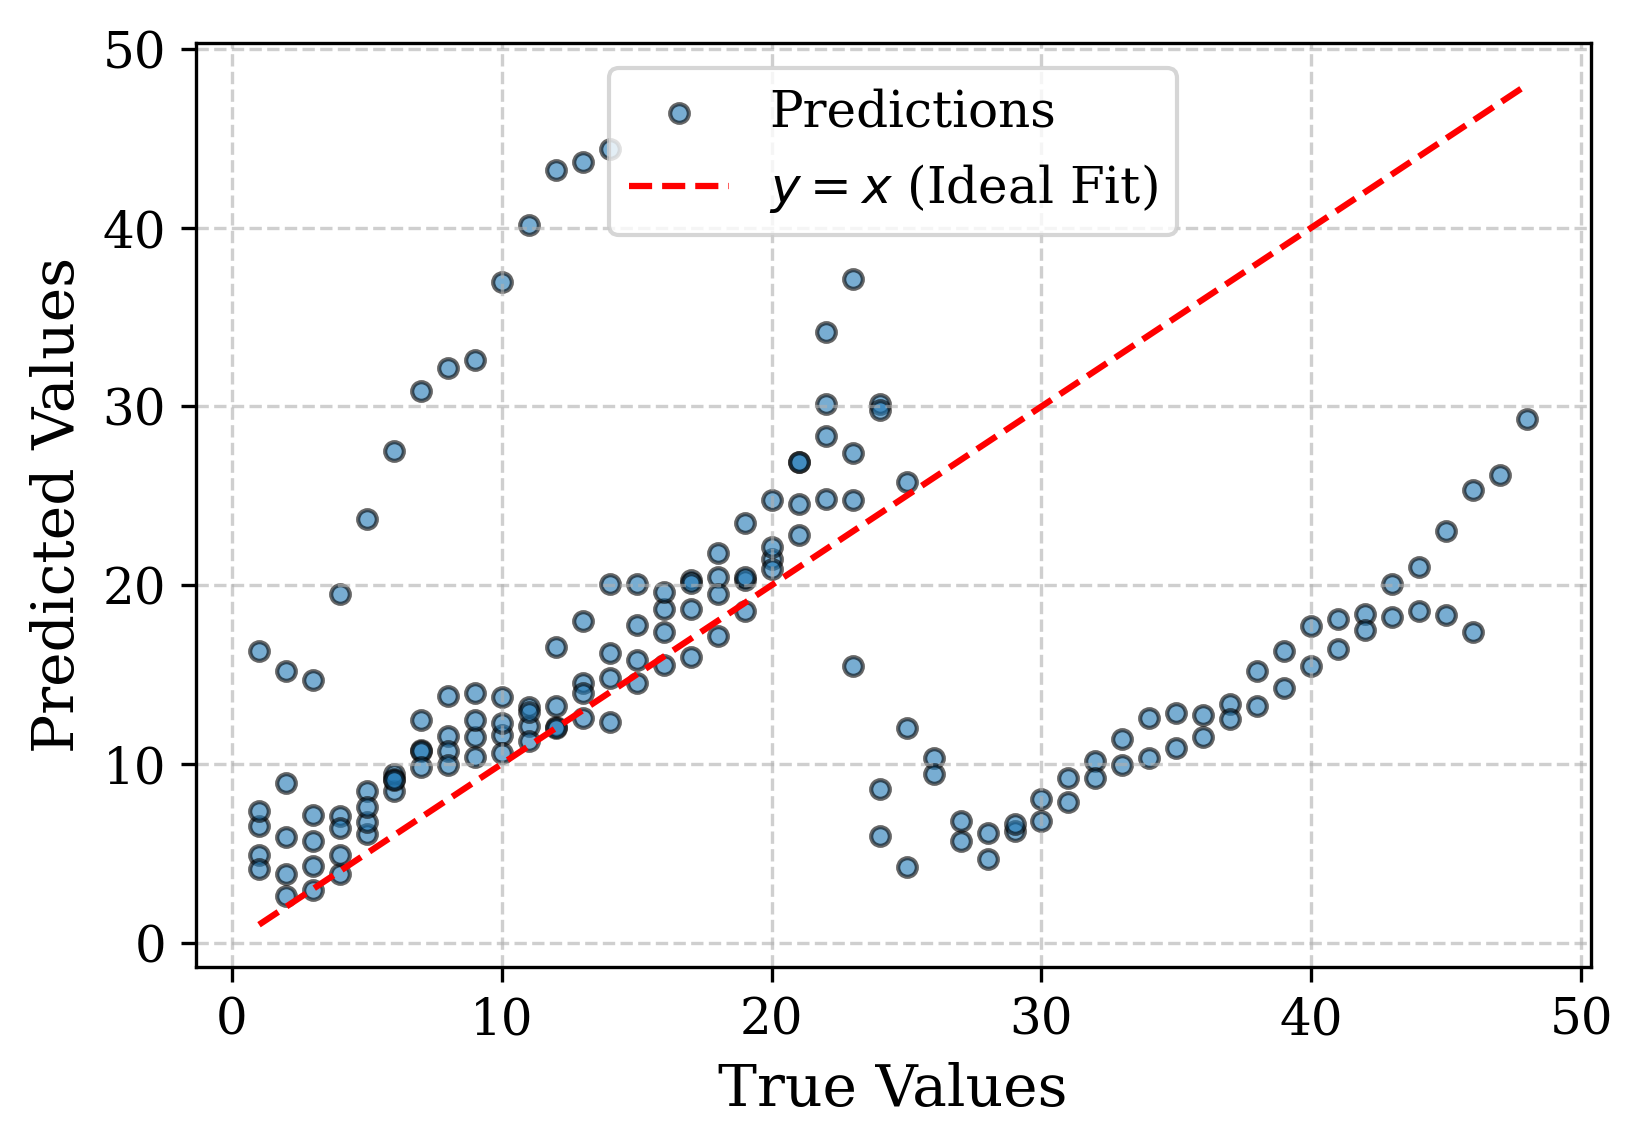

Evaluating motif 6 with size 12 and 38 indexes
X_series shape: torch.Size([979, 504, 1])
X_indices shape: torch.Size([979, 12, 1])
X_mask shape: torch.Size([979, 504])
y shape: torch.Size([979, 1])
Best epoch: 1
Test Loss: 122.77814483642578, Test MAE: 8.090044021606445, Test RMSE: 11.080530166625977
Best hyperparameters: {'learning_rate': 0.0004180380583245611, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 256}
Early stopping at epoch 12, with best epoch being 1


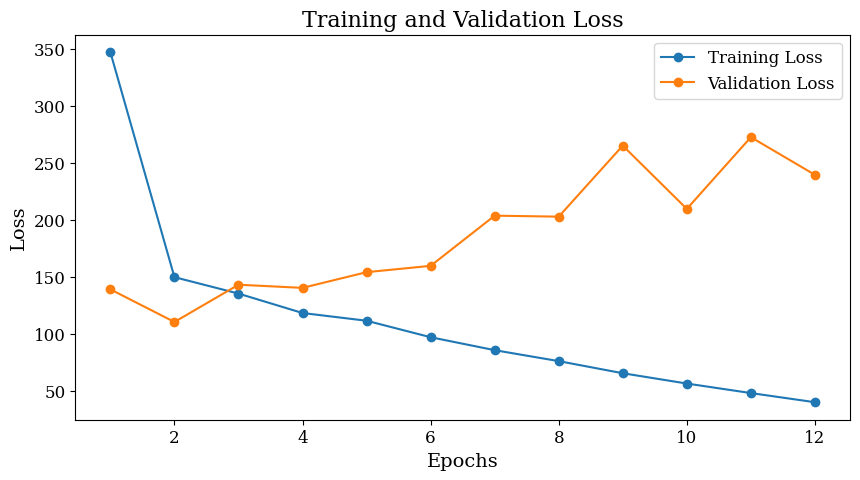

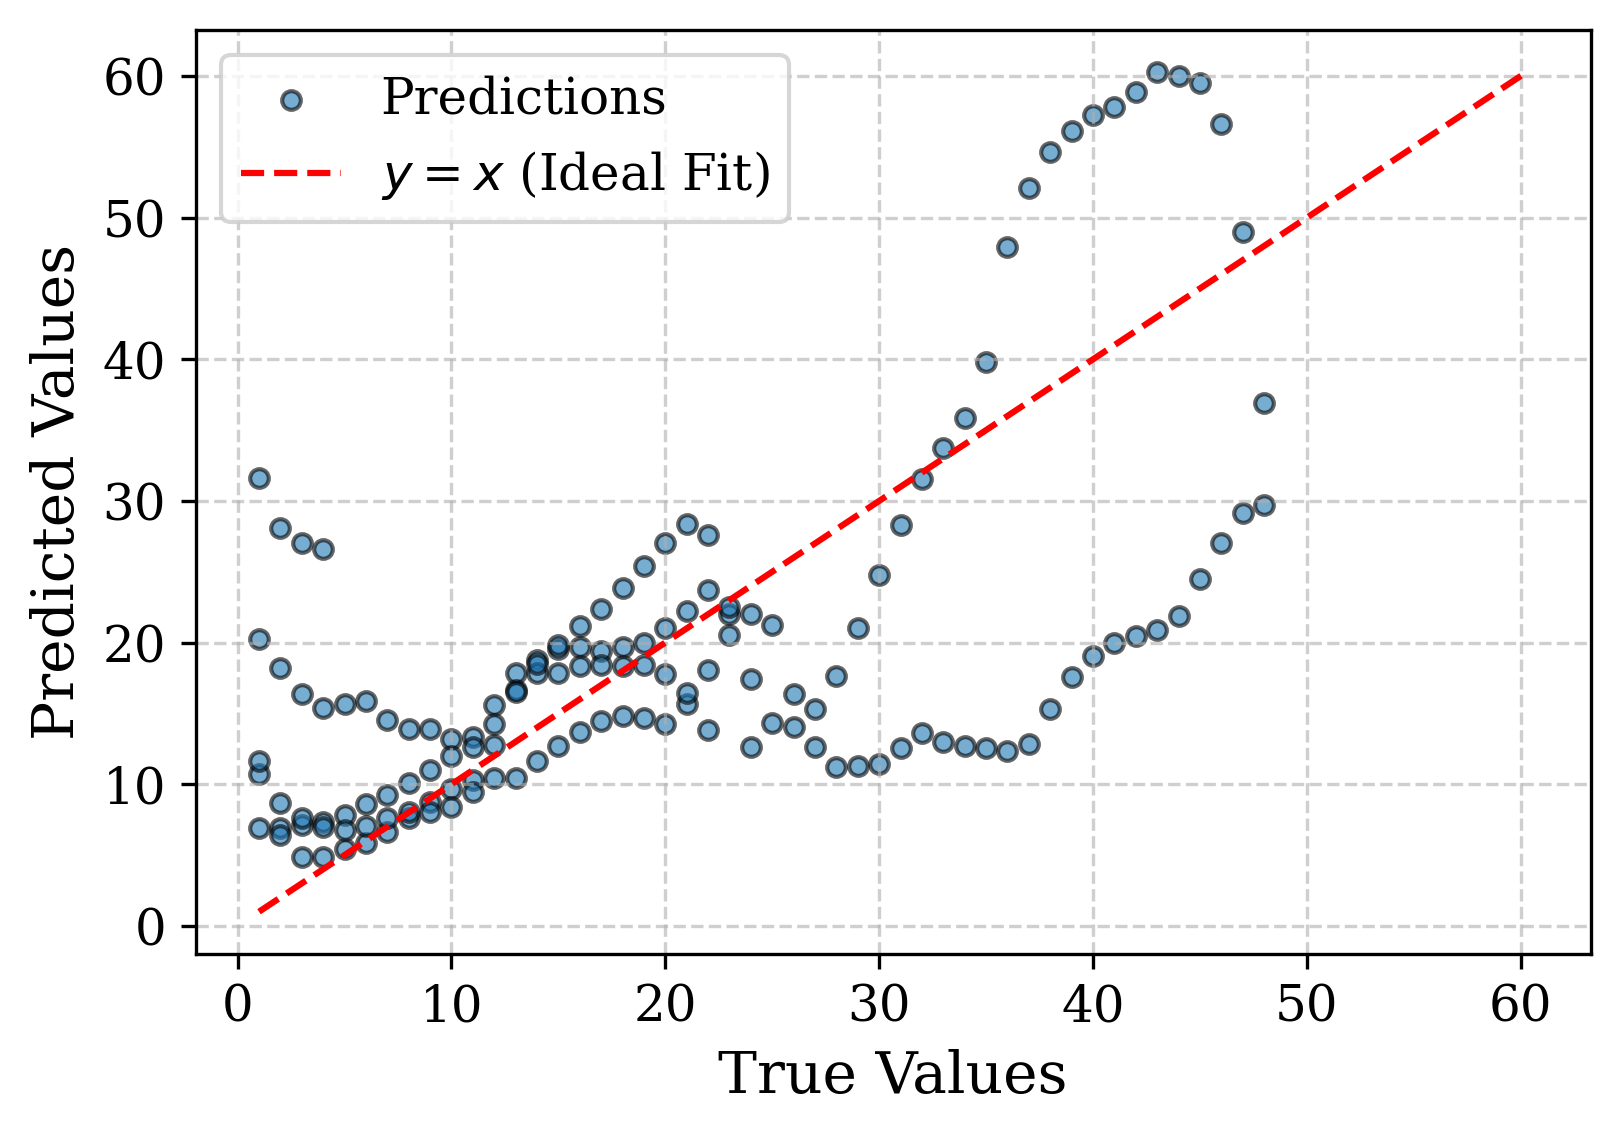

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 143.12116546630858 ± 36.79874817331497
Mean Test MAE: 9.164854812622071 ± 0.9946948119743958
Mean Test RMSE: 11.873959922790528 ± 1.4595358829897995


In [7]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


In [8]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNIndices"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])


FileNotFoundError: [Errno 2] No such file or directory: '/home/mgsilva/motifpred/results/populationdensity/FFNNIndices_100_trials_500_epochs_motif_27/study.pkl'